# Predicting memory encoding based neural population statespace reconstruction from ECoG data

In [124]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import sys

sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')

from nlds import delayembed as de
from nlds import dfa, utils, plotting
# import neurodsp as ndsp
from neurodsp import timefrequency, filt
from scv_funcs import lfpca
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Kahana Trialinfo Columns
- (1) taskphase - phase of the experiment, encoding = 1, recall = 2
- (2) stim           - indicating whether stimulation was present during encoding (1 = yes, 0 = no) (in case of recall, during encoding of the recalled word)
- (3) subseqmem  - subsequent memory effect, for encoding: later remembered = 1, later forgotten =  0; for recall: 1 = successfully remembered, 0 = new word
- (4) list  - list number (i.e. task phase)
- (5) serialpos - serial position of word in list during encoding (for recall, NaN in case of new word)
- (6) wordno - numeric identifier of word presented/recalled (for recall, NaN in case of new word)
- (7) timefromprev  - time in seconds from begsample till previous event (positive indicates overlap)
- (8) timetonext - time in seconds from endsample till next event     (negative indicates overlap)

In [272]:
datafile = '/Users/rdgao/Documents/data/Kahana/RAMPhase1_FR_Clean/R1020J_FR1_data_-800_2400.mat'
#datafile = '/Users/rdgao/Documents/data/Kahana/RAMPhase1_FR_Clean/R1032D_FR1_data_-800_2400.mat'
#datafile = '/Users/rdgao/Documents/data/Kahana/RAMPhase1_FR_Clean/R1033D_FR1_data_-800_2400.mat'
#datafile = '/Users/rdgao/Documents/data/Kahana/RAMPhase1_FR_Clean/R1034D_FR1_data_-800_2400.mat'
#datafile = '/Users/rdgao/Documents/data/Kahana/RAMPhase1_FR_Clean/R1045E_FR1_data_-800_2400.mat'

data = io.loadmat(datafile, squeeze_me=True)
x = data['dat']
fs = data['srate']
outcome = data['trialinfo'][:,2]
nchan, tr_len, ntrials = x.shape
t = np.arange(tr_len)/fs-0.8
pre_inds = np.arange(0*fs, 0.8*fs) # prestim
stim_inds = np.arange(1.2*fs, 2.2*fs) # stim
post_inds = np.arange(2.4*fs, 3.2*fs) # poststim
print(x.shape)
print(tr_len/fs, fs)
print(outcome.sum()/outcome.shape[0])

(59, 3200, 283)
3.2 1000
0.3674911660777385


# Processing
- for each type of signal (raw, low freq, hfa, noise, etc)
    - for each task epoch (all, pre, stim, post)
        - do NESCA
        - compute delay MI, tau
        - compute embedding dimension
        - compute 

In [3]:
def as_smooth_diff(x, N, window='hanning'):
    return np.append(0,np.diff(utils.smooth(x, N, window)))

highpass
Transition bandwidth is 21.5 Hz. Pass/stop bandwidth is 420.0 Hz
63


/Users/rdgao/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


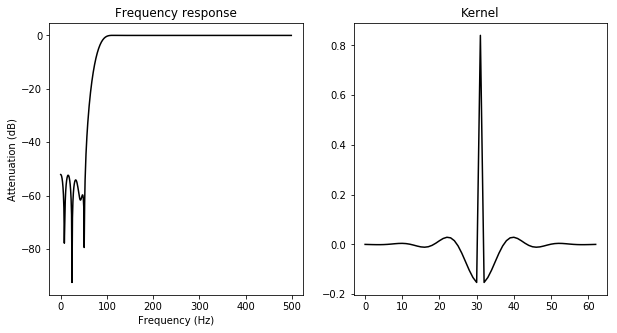

In [276]:
x_feat = np.empty_like(x)

f_range = (80,None)
#f_range = (40,55)
#f_range = (None,7)
n_cycles=5

lazy_pass = timefrequency._get_filt_passtype(f_range)
print(lazy_pass)
_, kernel = filt.filter_signal(x[0,:,0], fs, lazy_pass, f_range, n_cycles, plot_freq_response=True, return_kernel=True)
print(len(kernel))

for chan in range(nchan):
    for trial in range(ntrials):
        #x_feat[chan,:,trial] = as_smooth_diff(x[chan,:,trial], 51)
        x_feat[chan,:,trial] = timefrequency.amp_by_time(x[chan,:,trial], fs, f_range, filter_kwargs={'n_cycles':n_cycles}, verbose=False)
        #x_filt[chan,:,trial] = filt.filter_signal(x[chan,:,trial], fs, 'lowpass', f_range, n_cycles, verbose=False)



sig = x_amp
good_inds=~np.isnan(sig[0,:,0])

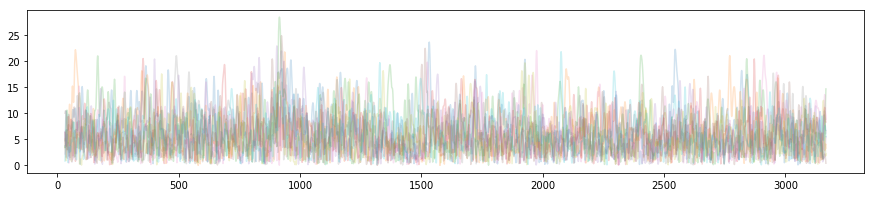

In [277]:
sig = x_feat
good_inds=~np.isnan(sig[0,:,0])
plt.figure(figsize=(15,3))
chan = 33
plt.plot(sig[chan,:,:10], alpha=0.2)

# compute MI and optimal delay

In [278]:
nbins, max_tau = 20, 200
MIs = []
for trial in range(ntrials):
    t_MI, MI = de.compute_delay_MI(sig[chan,good_inds,trial], nbins, max_tau)
    MIs.append(MI)

In [279]:
filt_lag = 0
opt_tau, opt_MI = [],[]
for MI in MIs:
    valley = de.find_valley(MI[filt_lag:])
    opt_tau.append(valley[0]+filt_lag)
    opt_MI.append(valley[1])
opt_tau = np.asarray(opt_tau)
opt_MI = np.asarray(opt_MI)

11.0


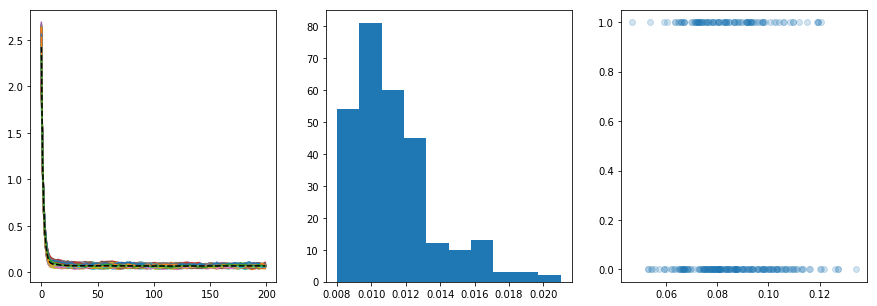

In [280]:
MIs = np.stack(MIs)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(t_MI[filt_lag:], MIs[:,filt_lag:].T);
plt.plot(t_MI[filt_lag:], MIs[:,filt_lag:].mean(axis=0), 'k--');

plt.subplot(1,3,2)
plt.hist(opt_tau/fs);

plt.subplot(1,3,3)
plt.plot(opt_MI,outcome, 'o', alpha=0.2)
print(np.median(opt_tau))

# Delay embedding

In [281]:
tau, max_dim = 30, 7
attr_dim = np.zeros(ntrials)
pfnn = np.zeros((ntrials,max_dim))
for trial in range(ntrials):
    #tau = opt_tau[trial]
    attr_dim[trial], pfnn[trial,:] = de.pfnn_de_dim(x_feat[chan, good_inds, trial], tau, max_dim)

Text(0.5,1,'p=0.0136')

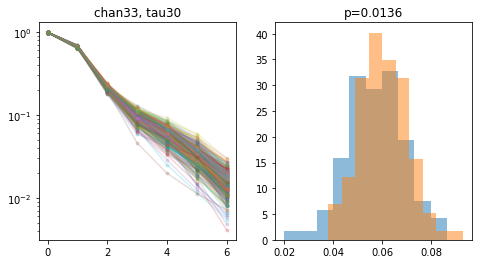

In [297]:
test_feats = [pfnn[:,4], attr_dim, opt_tau, opt_MI]
test_feat = test_feats[0]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.semilogy(pfnn.T, '.-', alpha=0.2);
plt.title('chan%i, tau%i'%(chan,tau))
plt.subplot(1,3,2)
plt.hist(test_feat[outcome==0], alpha=0.5, normed=True)
plt.hist(test_feat[outcome==1], alpha=0.5, normed=True)
plt.title('p=%.4f'%sp.stats.ttest_ind(test_feat[outcome==0],test_feat[outcome==1])[1])

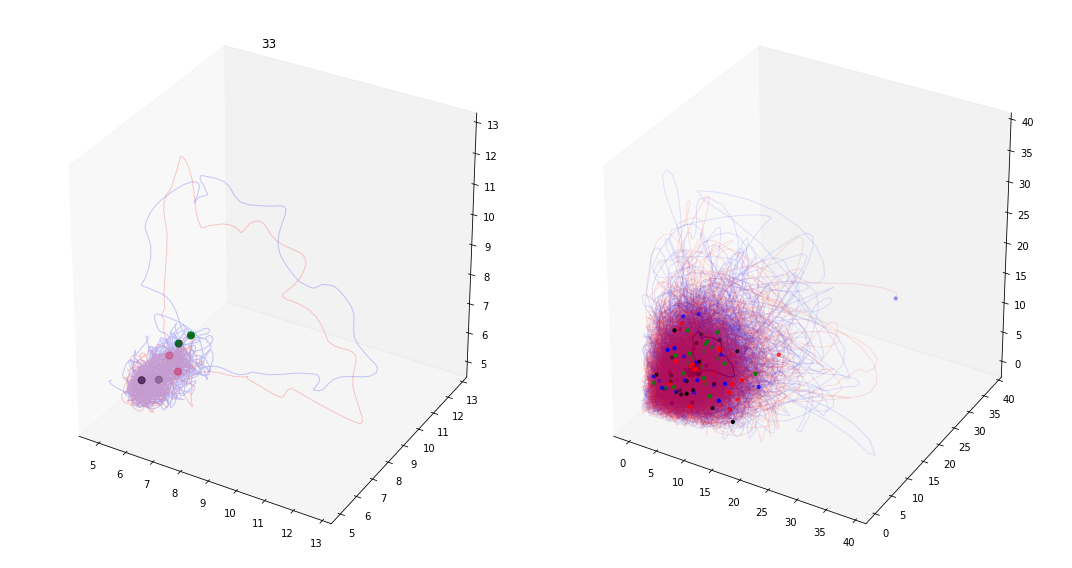

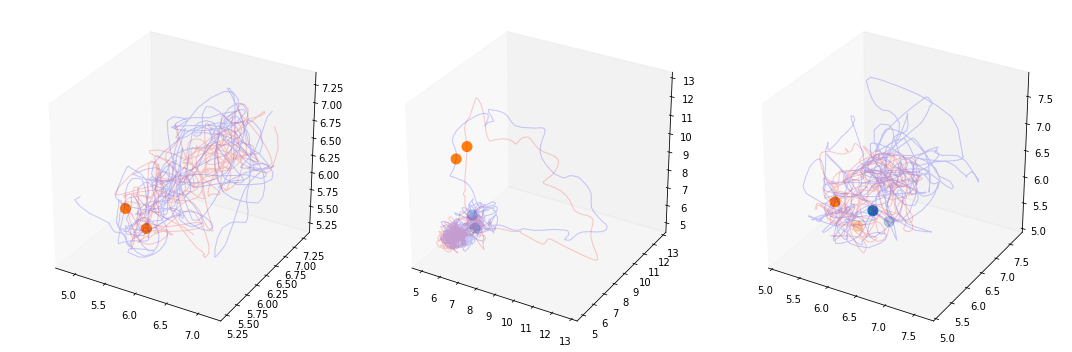

In [298]:
# sig = np.log10(x_amp**2)
# sig=x_amp
sig = x_feat

chan= 33 #9,10,24,25,28,31,32,33,34,39
dim,tau = 3, 30
inds = good_inds
mark_inds = np.array([pre_inds[0], pre_inds[-1], stim_inds[0], stim_inds[-1]]).astype(int)
mark_colors = ['b', 'r', 'g', 'k']

plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1,projection='3d')
x_de_0 = de.delay_embed(sig[chan,:][:, outcome==0].mean(-1),tau,dim)
x_de_1 = de.delay_embed(sig[chan,:][:, outcome==1].mean(-1),tau,dim)
plotting.plot_statespace_trial(x_de_0, ax=ax, step=1, lc='r', mark_ind=mark_inds, mark_color=mark_colors, alpha=0.2, ms=50)
plotting.plot_statespace_trial(x_de_1, ax=ax, step=1, lc='b', mark_ind=mark_inds, mark_color=mark_colors, alpha=0.2, ms=50)
plt.title(chan)
plt.tight_layout()

# plot grand average and some single trial trajectories
plt_trials = np.sort(np.random.randint(ntrials, size=3)) # random trials
plt_trials = np.where(data['trialinfo'][:,4]==3)[0] # same position in trial
ax = plt.subplot(1,2,2,projection='3d')
x_de = de.delay_embed(sig[chan,:,:].mean(-1),tau,dim)
plotting.plot_statespace_trial(x_de, ax, step=1, lc='k', mark_ind=mark_inds, mark_color=mark_colors, alpha=1, ms=20)
for i,trial in enumerate(plt_trials):    
    x_de = de.delay_embed(sig[chan,good_inds,trial],tau,dim)
    #x_de = de.delay_embed(smooth(sig[chan,good_inds,trial],200),tau,dim)
    plotting.plot_statespace_trial(x_de, ax, step=1, lc=['r','b'][int(outcome[trial])], mark_ind=mark_inds, mark_color=mark_colors, alpha=0.1, ms=10)

plt.tight_layout()

# plot mean trajectory in stages
plt.figure(figsize=(15,5))
for i,inds in enumerate([np.arange(0,800-tau*dim), np.arange(800,2400-tau*dim), np.arange(2400,3200-tau*dim)]):
    ax = plt.subplot(1,3,i+1, projection='3d')
    mark_inds = [0, 50]
    plotting.plot_statespace_trial(x_de_0[inds,:], ax=ax, lc='r', mark_ind=mark_inds, alpha=0.2, ms=100)
    plotting.plot_statespace_trial(x_de_1[inds,:], ax=ax, lc='b', mark_ind=mark_inds, alpha=0.2, ms=100)

plt.tight_layout()

# plt.figure(figsize=(15,15))
# plt_trials = np.sort(np.random.randint(ntrials, size=16))
# for i,trial in enumerate(plt_trials):
#     ax = plt.subplot(4,4,i+1, projection='3d')
#     #x_de = de.delay_embed(sig[chan,good_inds,trial],opt_tau[trial],3)
#     x_de = de.delay_embed(sig[chan,good_inds,trial],tau,dim)
#     #x_de = de.delay_embed(np.log10(sig[chan,good_inds,trial]**2),tau,dim)
#     ax = plotting.plot_statespace_trial(x_de, ax, step=1, mark_ind=mark_inds, mark_color=mark_colors, alpha=0.2, ms=50)
#     plt.title((trial, int(outcome[trial])))
    
# plt.tight_layout()



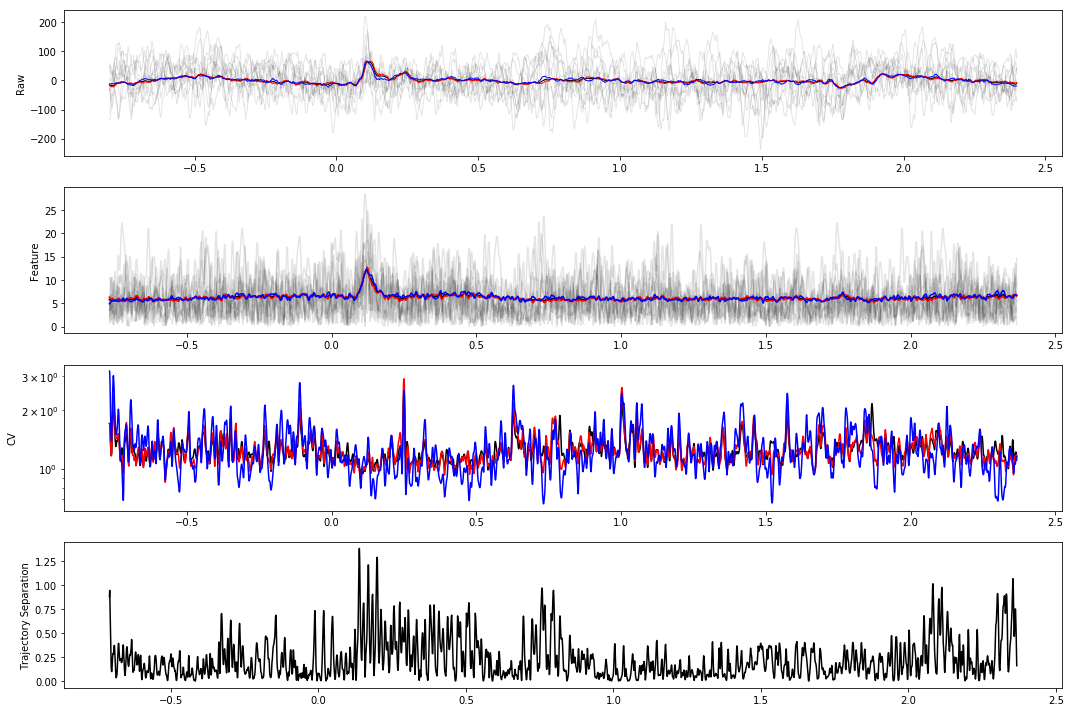

In [299]:
#chan=31 #9,10,24,25,28,31,32,33,34,39
#chan=16
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(t,x[chan,:,:10], 'k', lw=1, alpha=0.1);
plt.plot(t,x[chan,:,:].mean(-1), 'k', lw=1, alpha=1);
plt.plot(t,x[chan,:][:,outcome==0].mean(-1), 'r', lw=1, alpha=1);
plt.plot(t,x[chan,:][:,outcome==1].mean(-1), 'b', lw=1, alpha=1);
plt.ylabel('Raw')

plt.subplot(4,1,2)
plt.plot(t,(x_feat[chan,:,:10]), 'k', alpha=0.1);
plt.plot(t,(x_feat[chan,:,:]).mean(-1), 'k');
plt.plot(t,(x_feat[chan,:][:,outcome==0]).mean(-1), 'r');
plt.plot(t,(x_feat[chan,:][:,outcome==1]).mean(-1), 'b');

XL = plt.xlim()
plt.ylabel('Feature')

plt.subplot(4,1,3)
x_trans = x_feat**2
plt.semilogy(t,(x_trans[chan,:,:]).std(axis=-1)/(x_trans[chan,:,:]).mean(axis=-1), 'k');
plt.semilogy(t,(x_trans[chan,:][:,outcome==0]).std(-1)/(x_trans[chan,:][:,outcome==0]).mean(-1), 'r');
plt.semilogy(t,(x_trans[chan,:][:,outcome==0]).std(-1)/(x_trans[chan,:][:,outcome==1]).mean(-1), 'b');
plt.ylabel('CV')

plt.subplot(4,1,4)
dist = ((x_de_0-x_de_1)**2).mean(-1)
plt.plot(t[tau*(dim-1):dist.shape[0]+tau*(dim-1)], dist, 'k')
#plt.xlim(XL)
plt.ylabel('Trajectory Separation')
plt.tight_layout()

# Effect of tau & PCA

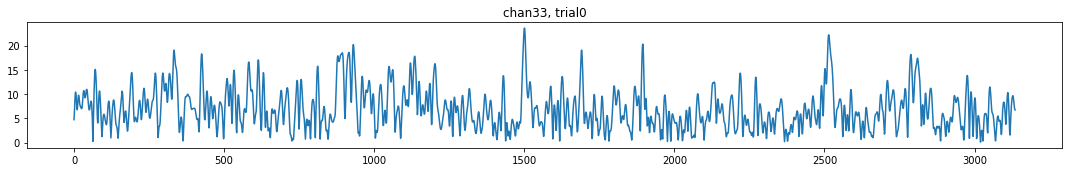

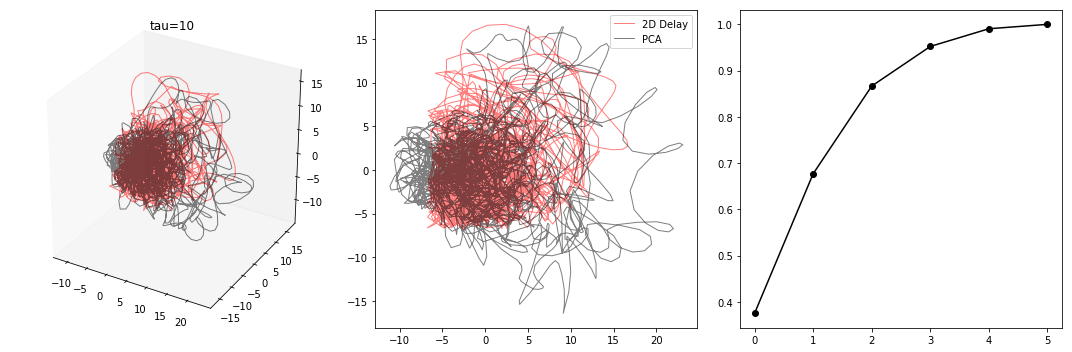

In [333]:
chan, trial, tau, max_dim = 33, 0, 10, 8
sig = x_feat[chan, good_inds, trial]
#sig = x_feat[chan, good_inds, :].mean(-1)
x_de = de.delay_embed(sig-sig.mean(), tau, max_dim)
x_pca = decomposition.PCA(n_components=max_dim).fit_transform(x_de)

plt.figure(figsize=(15,2.5))
plt.plot(sig)
plt.title('chan%i, trial%i'%(chan, trial))
plt.tight_layout()

plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1, projection='3d')
plotting.plot_statespace_trial(x_de[:,:3], ax, lc='r', alpha=0.5)
plotting.plot_statespace_trial(x_pca[:,:3], ax, alpha=0.5)
plt.title('tau=%i'%tau)

ax = plt.subplot(1,3,2)
plotting.plot_statespace_trial(x_de[:,:2], ax, lc='r', alpha=0.5)
plotting.plot_statespace_trial(x_pca[:,:2], ax, alpha=0.5)
plt.legend(['2D Delay', 'PCA'])

plt.subplot(1,3,3)
plt.plot(pca.explained_variance_ratio_.cumsum(), 'ok-')
plt.tight_layout()

In [334]:
max_dim = 7
taus = np.arange(5,300,5)
attr_dim = np.zeros(taus.shape[0])
pfnn = np.zeros((taus.shape[0],max_dim))
for t_ in range(taus.shape[0]):
    tau = taus[t_]
    attr_dim[t_], pfnn[t_,:] = de.pfnn_de_dim(x_feat[chan, good_inds, trial], tau, max_dim)

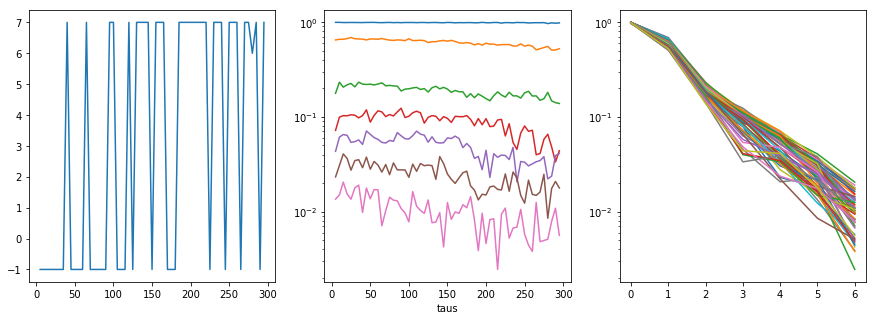

In [335]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(taus, attr_dim)
plt.subplot(1,3,2)
plt.semilogy(taus,pfnn[:,:]);
plt.xlabel('taus')
plt.subplot(1,3,3)
plt.semilogy(pfnn.T);